# TP 2: Reconstruction tomographique

### Par Mathieu Marquis, Charles-Antoine Parent et Thomas Piuze

In [1]:
import numpy as np
import scipy as sp

from devoirs.tp2 import geo, util, CTfilter, recon

## Questions:

### 1- Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l’eau pour des photons de 60 keV, à une masse volumique de 1.0 g/cm $^3$. Quelle fraction du signal subsiste après avoir traversé 5 cm d’eau ; 20 cm d’eau ?

Selon les données XCOM du NIST [1], l'atténuation totale dans l'eau pour des photons de 60 keV en considérant la diffusion cohérente est de $2.059\times10^{-1}$ cm $^2$ /g. En multipliant cette atténuation par la masse volumique de l'eau ($\approx 1$ g cm $^{-3}$), on obtient un coefficient d'atténuation linéaire de $2.059\times10^{-1}$ cm $^{-1}$. Puisque ce coefficient est une constante et non une fonction de la distance $x$ parcourue, l'intensité en fonction de $x$ est:
$$ I(x) = I_0e^{-\int_0^x\mu(x')dx'} = I_0e^{-\mu\int_0^xdx'} = I_0e^{-\mu x} \longrightarrow \frac{I(x)}{I_0} = e^{-\mu x} $$ 
Après avoir traversé 5 cm et 20 cm d'eau, la fraction subsistante du signal est:
$$ \frac{I(5)}{I_0} = e^{-2.059\times10^{-1}\ \cdot\ 5} \approx 0.3572 \approx 35.72\% \\
\frac{I(20)}{I_0} = e^{-2.059\times10^{-1}\ \cdot\ 20} \approx 0.01628 \approx 1.628\% $$

Ces résultats illustrent la non-linéarité de l'atténuation, typique d'une exponentielle décroissante.

### 2- En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée *laminogramme*, des données de projection fournies. Notez qu’une approche par *slicing* pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur). 

### Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image de référence (fantôme) ?

Pour chaque voxel, il faut déterminer la distance $d$ par rapport au centre du détecteur à laquelle parvient un rayon partant du voxel considéré et qui frappe le détecteur à un angle de 90 degrés. En exprimant la position des voxels par rapport à l'isocentre à l'aide des coordonnées polaires $r$ et $\phi$, on trouve à l'aide d'un peu de géométrie que cette distance $d$ est:
$$ d = r\cos(\phi-\theta) $$
où $\theta$ est l'angle de la projection. Cette distance est utilisée dans la fonction suivante, qui permet de construire le laminogramme à partir des données fournies.

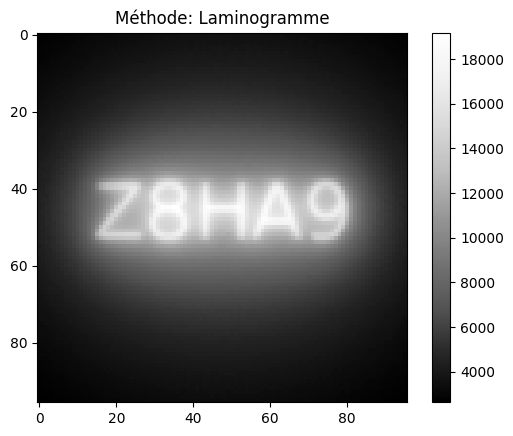

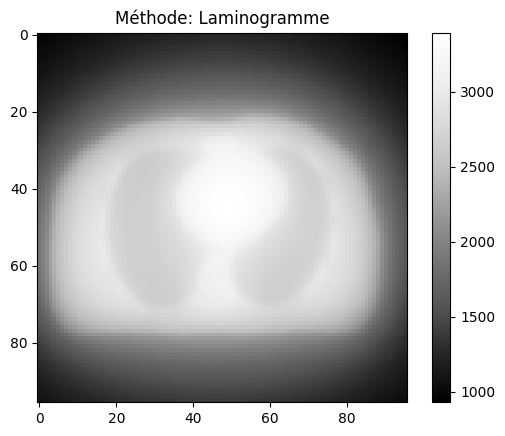

In [3]:
def laminogram(filename: str=geo.sinogramFile, size: float=geo.nbvox, filtre: bool=False):
    [nbprj, angles, sinogram] = recon.readInput(filename=filename)

    # Filtre du sinogramme si spécifié
    if filtre is True:
        sinogram = filterSinogram(sinogram)

    # Initialisation de la grille
    a, b = np.meshgrid(np.arange(size), np.arange(size))

    # Coordonnées cartésiennes de la grille
    voxsize = geo.nbvox*geo.voxsize/size
    x = (b-0.5*(size-1))*voxsize 
    y = (a-0.5*(size-1))*voxsize

    # Conversion en coordonnées polaires
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y, x)

    # Création d'un array 3d pour le cos avec toutes les valeurs des angles
    temp = np.cos(np.subtract.outer(phi, angles))

    # Calcul du pixel correspondant pour chaque élément de l'array 3d
    d = np.einsum('ij,ijk->ijk', r, temp)
    nb_pixels = d//geo.pixsize
    pixel = np.round(geo.nbpix/2+nb_pixels).astype(int)

    # Attribution de l'intensité associée à chaque pixel
    intensite = sinogram[np.indices((size, size, len(angles)))[2], pixel]

    # Somme des intensités pour chaque angle et rotation pour l'affichage de l'image
    image = np.rot90(np.sum(intensite, axis=2), -1)
    
    util.saveImage(image, "Laminogramme")

laminogram("sinogram-password.txt")
laminogram("sinogram-patient.txt")

Le code permettant d'avoir accès au fantôme numérique est Z8HA9. En comparant le fantôme numérique à l'image reconstruite, on constate que cette dernière est moins détaillée, moins contrastée et plus diffuse. Les formes générales sont présentes, mais l'intensité de la partie centrale est diffusée sur le contour, qui devrait être plus sombre. Les frontières entre les différents éléments sont moins nettes, et les détails sont presque totalement absents. Il est seulement possible de distinguer les poumons du reste du corps, alors que l'image de référence comportait plusieurs teintes et détails secondaires.

### 3- En utilisant la librairie `numpy.fft`, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré ?

Le sinogramme fourni est affiché par le code suivant:

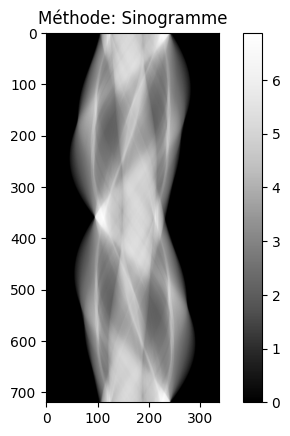

In [4]:
sinogram = recon.readInput()[2]
util.saveImage(sinogram, "Sinogramme")

On définit ensuite une fonction pour filtrer ce sinogramme à l'aide d'un filtre rampe.

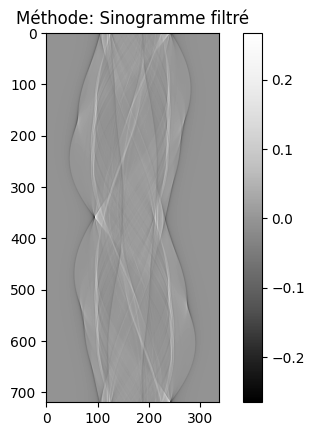

In [5]:
def filterSinogram(sinogram: list) -> list:
    for i in range(sinogram.shape[0]):
        freq = np.fft.rfft(sinogram[i])
        freq_filtrees = freq*np.abs(np.fft.rfftfreq(len(sinogram[i])))
        sinogram[i] = np.fft.irfft(freq_filtrees)

    return sinogram

sinogram_filtre = filterSinogram(recon.readInput()[2])
util.saveImage(sinogram_filtre, "Sinogramme filtré")

On constate que le sinogramme filtré conserve les détails, tout en étant beaucoup moins contrasté que le sinogramme original. Les détails sont autant nets, voire davantage que pour l'original, et la forme générale est reconnaissable. Cependant, la variation d'intensité est nettement moins grande et l'échelle des valeurs se situe maintenant à l'intérieur de -0.25 à 0.25, alors que le sinogramme original possédait des valeurs dans l'intervalle [0,7] approximativement.

### 4- Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant idéalement le code précédent du laminogramme. Comparez l’image obtenue avec le fantôme. Quelles différences observez-vous ? Où sont situées les erreurs et que diriez- vous de la fréquence spatiale des erreurs ?

Il suffit d'activer le filtre dans le code utilisé pour construire le laminogramme.

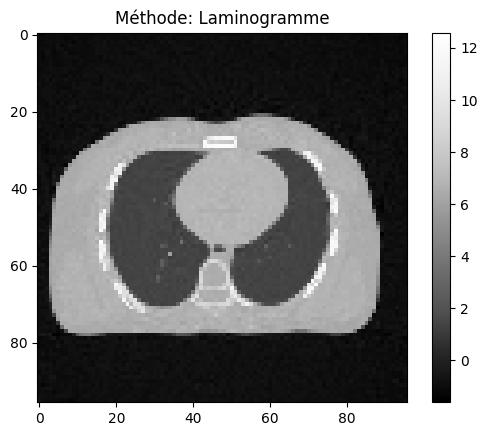

In [6]:
laminogram(filtre=True)

En comparant l'image obtenue avec le fantôme, on constate que la ressemblance est beaucoup plus importante qu'avec le laminogramme sans filtre. La résolution limitée est cependant perceptible, puisqu'il est maintenant possible de distinguer les pixels individuels, l'image étant très pixelisée. On remarque que les erreurs principales se situent dans les poumons et autour de ceux-ci, où un léger bruit aléatoire est introduit. Ces fluctuations n'étant pas présentes dans le fantôme sont attribuables à des erreurs d'une grande fréquence spatiale, affectant la reconstruction aléatoirement. On constate que les petits détails sont moins bien définis, ce qui peut être attribué à la discrétisation des données, mais aussi aux petites dimensions de la grille. Néanmoins, les détails du fantôme original sont mieux conservés que la méthode sans filtre et la grande majorité des structures sont facilement distinguables.

### 5- Écrivez une nouvelle fonction de reconstruction `reconFourierSlice()` qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effectuer la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l’espace de Fourier 2D de l’image à reconstruire. Vous pouvez choisir l’angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l’image par TF $^{-1}_{2D}$ et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l’initialisation suivante `mymatrix = numpy.zeros((a,b), ’complex’)`, puis prenez la partie réelle de l’image finale.

La fonction suivante effectue la reconstruction de l'image à l'aide du théorème de la tranche de Fourier.

In [ ]:
def reconFourierSlice(nbvox: int=geo.nbpix):
    _, angles, sinogram = recon.readInput()

    sinogram_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=1)), axes=1)

    r, theta = np.arange(-geo.nbpix/2, geo.nbpix/2), np.pi - angles
    r, theta = np.meshgrid(r, theta)

    # Points de la grille polaire correspondant aux valeurs de la fft du sinogramme
    points = np.stack([(geo.nbpix / 2 + r*func(theta)).flatten() for func in [np.sin, np.cos]], axis=1)

    # Points de la grille d'image où échantillonner la fft du sinogramme
    grid_x, grid_y = np.meshgrid(np.arange(nbvox), np.arange(nbvox))

    # Interpolation sur les données du sinogramme (converties de polaire à cartésien) pour trouver la valeur des pixels
    # de la grille d'image
    fft2 = sp.interpolate.griddata(
        points,
        sinogram_fft.flatten(),
        (grid_y.flatten(), grid_x.flatten()),
        method="linear",
        fill_value=0,
    ).reshape((nbvox, nbvox))

    reconstruction = np.abs(np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft2)))))

    util.saveImage(reconstruction, "Tranche de Fourier")


reconFourierSlice()


On remarque que cette méthode permet d'obtenir des reconstructions bien plus précises et contrastées par rapport aux méthodes de rétroprojection simple ou filtrée. En utilisant la transformée de Fourier, cette méthode permet de capturer plus fidèlement les détails fins de l'objet, ce qui se traduit par une meilleure résolution spatiale. La reconstruction obtenue est généralement plus contrastée, ce qui permet de mieux distinguer les différentes structures internes de l'objet. Finalement, on ne distingue aucun artefact de reconstruction contrairement aux flous précédents.

Il est toutefois important de noter que cette méthode est extrêment sensible à la taille de la grille de reconstruction. Effectivement, il a été remarqué que la taille optimale correspond à la dimension du détecteur, et que pour des tailles intermédiaires, des artefacts majeurs pouvaient apparaître. Cela peut être dû à l'interpolation des fonctions continues sur une grille discrète, ce qui peut occasionner des approximations et arrondissements donnant lieu à des tendances non voulues. Les cellules suivantes illustrent la reconstruction pour une grille de 335x335, soit très près de la grille de la figure précédente (336x336), et pour une grille de 96x96 comme les reconstructions effectuées par les autres méthodes.

In [ ]:
reconFourierSlice(335)

In [ ]:
reconFourierSlice(geo.nbvox)

On déduit donc qu'il est très important de choisir adéquatement le nombre de voxels sur lequel effectuer la reconstruction.

# Références

[1] NIST XCOM. (s. d.). NIST XCOM: Physical Meas. Laboratory: Element/Compound/Mixture. https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html